# Inference

This notebook demonstrates model inference using a trained image captioning model. The saved model and vocabulary are loaded to generate captions for unseen images in evaluation mode. It covers image preprocessing, caption generation, and visualization of results to qualitatively assess model performance.

In [1]:
# Configuration
EMBED_SIZE = 256
HIDDEN_SIZE = 512
NUM_LAYERS = 1
MODEL_PATH = './trained/best_model.pth'
VOCAB_PATH = './trained/vocab.pkl'

START, END, PAD, UNKNOWN = '<START>', '<END>', '<PAD>', '<UNK>'


class Vocabulary:
    """Vocabulary class to handle word-to-index and index-to-word mappings"""

    def __init__(self, freq_threshold=5):
        self.itos = {0: PAD, 1: UNKNOWN, 2: START, 3: END}
        self.stoi = {PAD: 0, UNKNOWN: 1, START: 2, END: 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    def numericalize(self, text):
        return [self.stoi.get(tok, self.stoi[UNKNOWN]) for tok in text.split()]

In [2]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [3]:
import pickle

# Load vocabulary
with open(VOCAB_PATH, 'rb') as f:
    vocab = pickle.load(f)

vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 4076


In [4]:
from model import ImageCaptioningModel

# Load model
model = ImageCaptioningModel(EMBED_SIZE, HIDDEN_SIZE, vocab_size, NUM_LAYERS)
checkpoint = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()
print("\nModel loaded")

C:\Users\kotik\AppData\Local\Programs\Python\Python314\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\kotik\AppData\Local\Programs\Python\Python314\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Model loaded


In [5]:
import torchvision.transforms as transforms

# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [6]:
from PIL import Image

def generate_caption(image_path: str, model: ImageCaptioningModel, vocab: Vocabulary, max_length=20) -> str:
    """
    Generate a caption for a single image.

    Args:
        image_path: Path to the image file
        model: Trained ImageCaptioningModel
        vocab: Vocabulary object
        max_length: Maximum caption length

    Returns:
        Caption string
    """
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Generate caption IDs
    with torch.no_grad():
        caption_ids = model.generate_caption(image_tensor, vocab, max_length) # to avoid headache

    # Convert IDs to words and remove special tokens
    words = [vocab.itos[idx] for idx in caption_ids if vocab.itos[idx] not in [START, END, PAD]]
    caption = ' '.join(words)

    return caption

The core caption generation logic is implemented inside the ImageCaptioningModel. This method performs greedy decoding by iteratively feeding image features and previously predicted tokens into the LSTM, updating hidden states, and selecting the most probable next token at each step.

I placed core logic of feature reshaping, hidden-state management, and token prediction inside `ImageCaptioningModel`. Placing it in a single method makes the logic dense and harder read.

Following code is snipped from `model.py` inside model definition.
```
    def generate_caption(self, features, vocab, max_length=20):
        """
        Generate caption for a single image using greedy search
        """
        result = []
        states = None

        inputs = features.unsqueeze(1)

        for i in range(max_length):
            hiddens, states = self.lstm(inputs, states)
            outputs = self.linear(hiddens.squeeze(1))
            predicted = outputs.argmax(1)

            result.append(predicted.item())

            inputs = self.embed(predicted).unsqueeze(1)

        return result
```

In [7]:
import matplotlib.pyplot as plt

def visualize_single_image(image_path: str, caption: str):
    # Load image
    image = Image.open(image_path).convert('RGB')
    width, height = image.size

    # Plot
    plt.figure(figsize=(width / 50, height / 50))  # scale figure size for better display
    plt.imshow(image)
    plt.xlabel(f'Width {width} pixels')
    plt.ylabel(f'Height {height} pixels')
    plt.title(f"{caption}", fontsize=14, pad=20)
    plt.axis('on')  # show pixel axes
    plt.show()

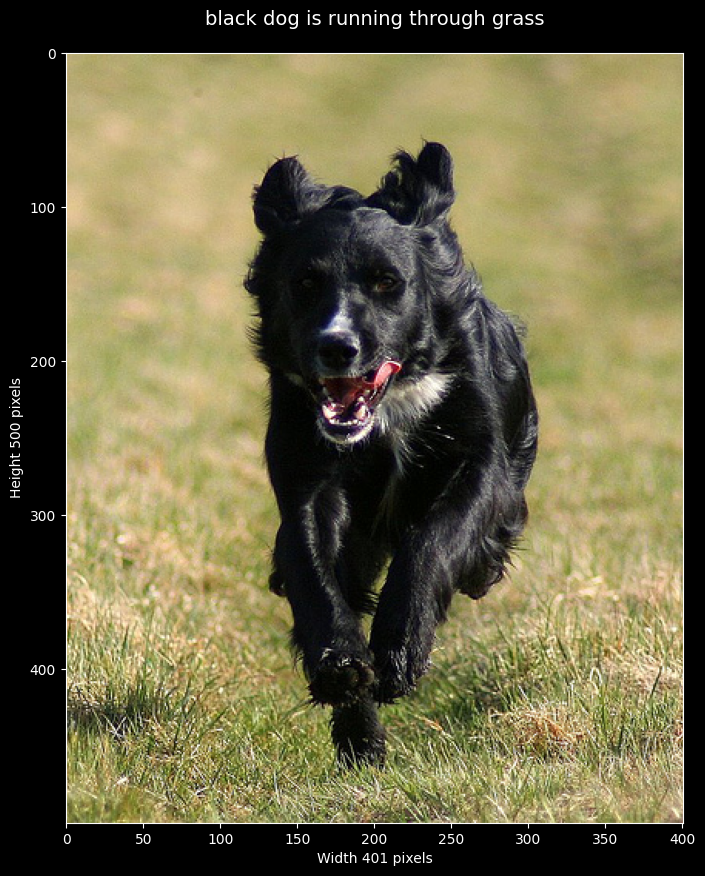

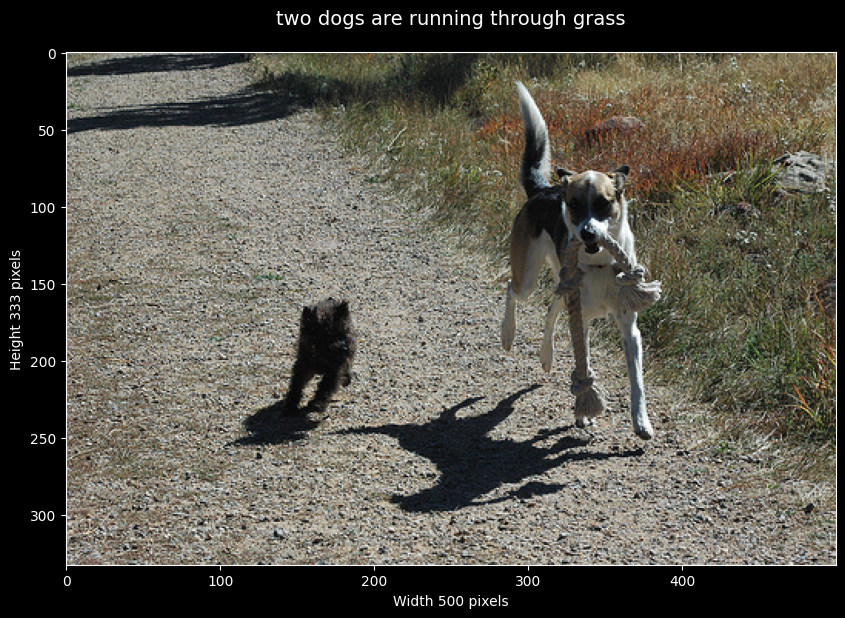

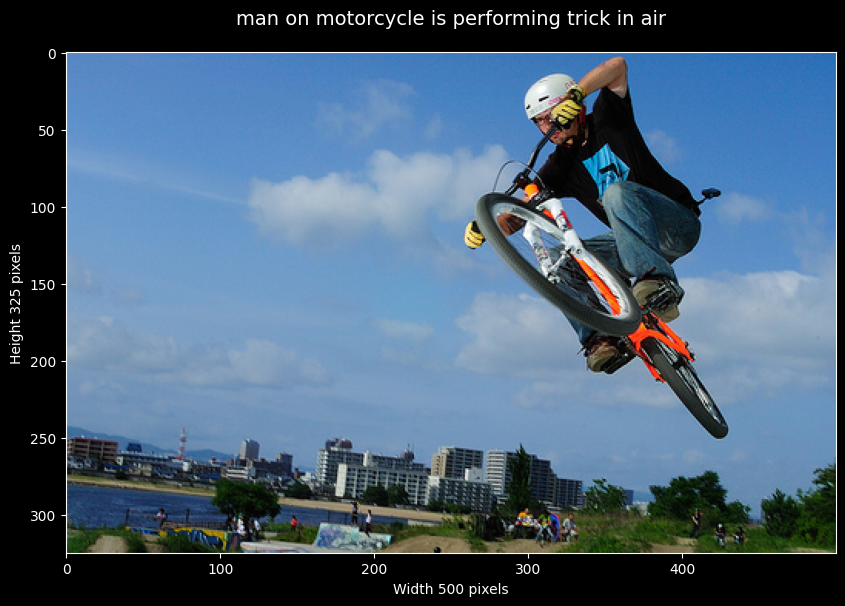

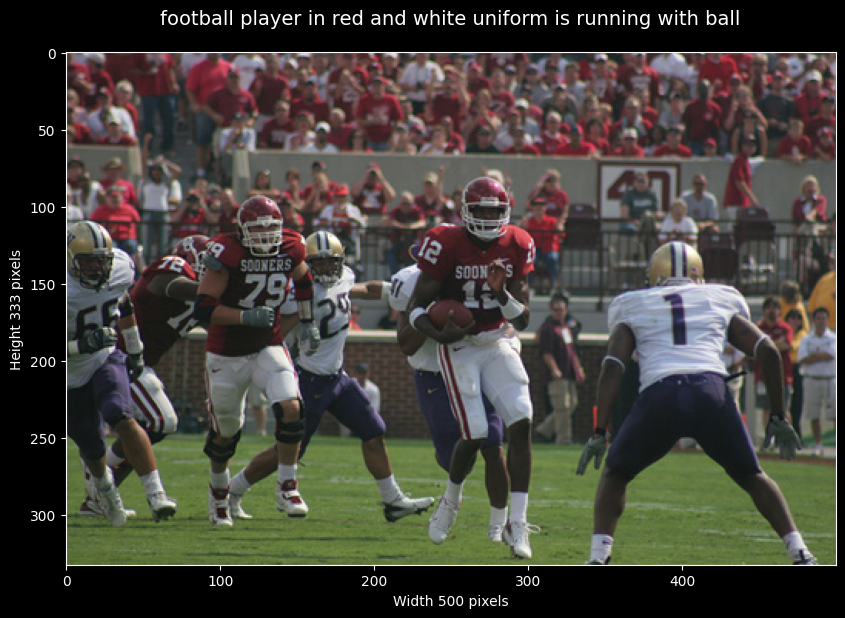

In [8]:
test_images = [
    './caption_data/Test Images/3419634480_c390f62a6e.jpg',
    './caption_data/Test Images/1470536919_1f3fd6c65a.jpg',
    './caption_data/Test Images/3602676311_824b2c04ba.jpg',
    './caption_data/Test Images/241346580_b3c035d65c.jpg'
]

for i in range(len(test_images)):
    image_path = test_images[i]
    caption = generate_caption(image_path, model, vocab)
    visualize_single_image(image_path, caption)


The model is able to generalize to unseen images, but in some cases it fails to accurately capture or describe the scene. Below are examples where the generated captions are incomplete, vague, or incorrect.

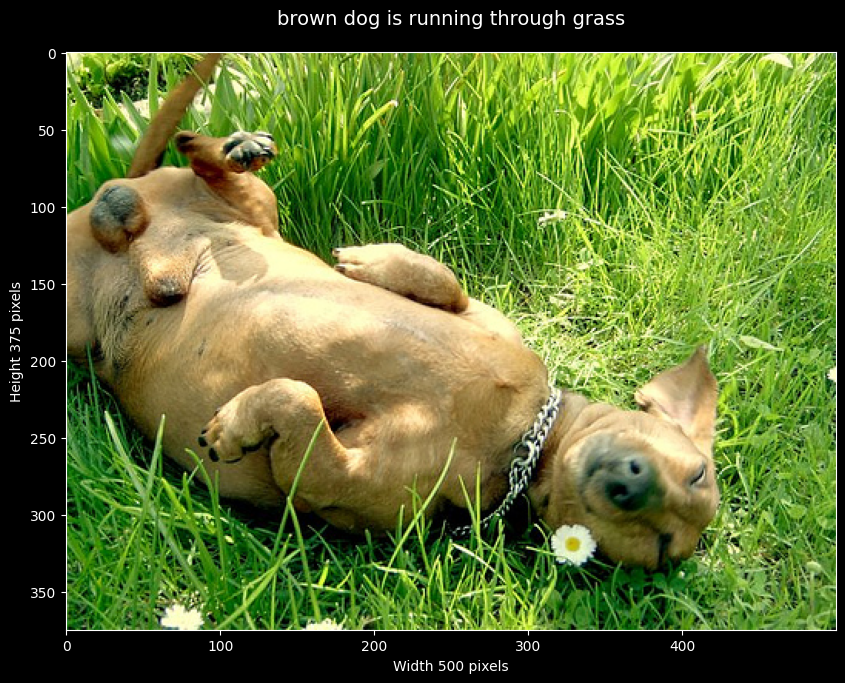

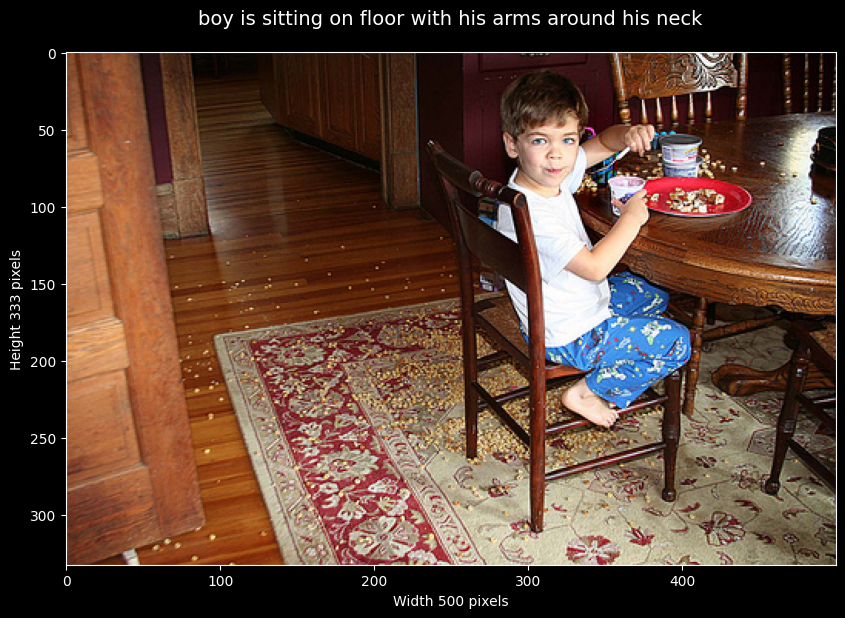

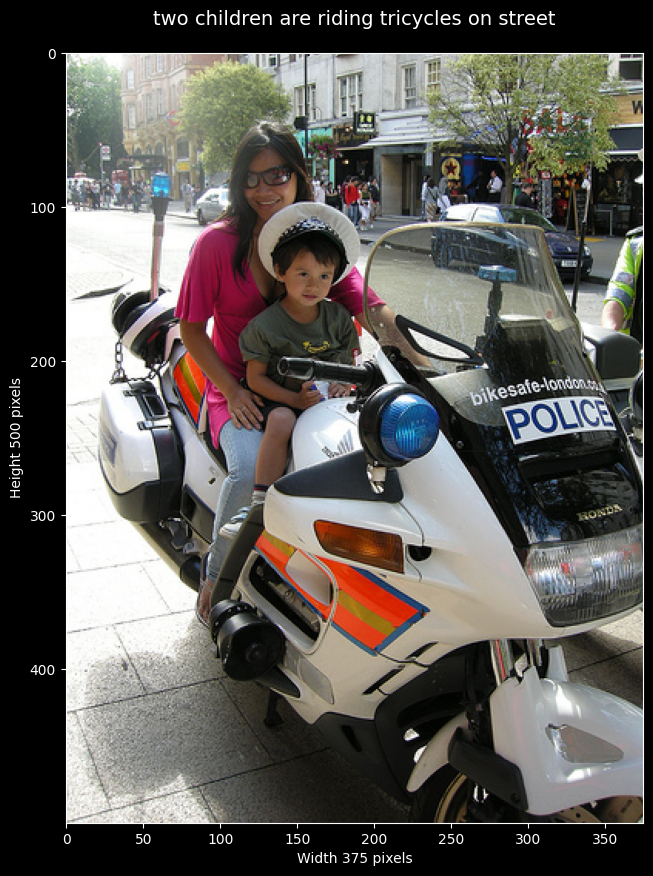

In [9]:
failing_images = [
    './caption_data/Images/229862312_1a0ba19dab.jpg',
    './caption_data/Images/2675685200_0913d84d9b.jpg',
    './caption_data/Images/1251558317_4ef844b775.jpg'
]

for i in range(len(failing_images)):
    image_path = failing_images[i]
    caption = generate_caption(image_path, model, vocab)
    visualize_single_image(image_path, caption)

Overall, the model is strong at recognizing actions, but it struggles to accurately identify human age and gender, often confusing men, women, and children.

The dataset also appears to be heavily biased toward images of dogs running on grass; as a result, whenever both grass and a dog are present, the model frequently defaults to predicting a “running” action, even when the scene suggests otherwise.